# OOI Profile Examples - WHOI Data Tutorial
*Written by Sage Lichtenwalner, Rutgers University, August 4, 2020*

The example was developed as a Data Tutorial for the [WHOI Ocean Informatics Working Group](https://www2.whoi.edu/site/oceaninformatics/).

## Introduction
Working with data from the OOI presents a few challenges to a new user.  But the good news is, once you figure out how to load a dataset from one instrument, which only takes a few lines of code in Python, you then have all the tools you need to load data from almost any instrument available in the [OOI Data Portal](https://ooinet.oceanobservatories.org).

All of the data in the Data Portal is made available in the same format (basically a **1-dimensional timeseries** available as either **downloadable NetCDF files** or via a **THREDDS** server).  

Thus, you can use the same code to access data from fixed instruments on moorings, underwater nodes, wire-following profilers, or even gliders.  Even ADCP and OPTAA data is very similar in format (albeit with a 2nd dimension for bin or frequency), making them easy to work with as well.

That said, data from **profilers and gliders** present more of a challenge, because the actual data we want is in 3D (time, depth and measured variable), which requires more advanced plotting techniques.  In addition, there are often other quirks in the dataset that have to be dealt with.

<img src="https://oceanobservatories.org/wp-content/uploads/2015/09/CEV-OOI-Coastal-Pioneer-Array.jpg" alt="OOI Coastal Pioneer Array" width="600px">

In this Python notebook, we will demonstrate how to access and plot some profiler and glider data from the Ocean Observatories Initiative (OOI), specifically from the Pioneer Array.

This example was designed to run on Google's Colaboratory platform, though it should also work on any Jupyter notebook platform, assuming the required libraries are installed.

## 1. Requesting Data
As of July 2020, in order to use data from the OOI, you must first request the dataset that you are interested in, including the instrument, "method", "stream", and time range that you want.

There are two ways to do this:
* Use the [OOI Data Portal](http://ooinet.oceanobservatories.org) - Good for exploring what's available, and when you only want to make a few requests.
* Use the API - Good for when you want to make a lot of requests (e.g. for different instruments or time ranges).  

This example assumes you've already requested the data and have a "THREDDS URL" to work with.  To learn more about how to make a request via the API, check out this [example](https://github.com/ooi-data-lab/datalab-blog-examples/blob/master/2020/03_How_to_Request_OOI_Data.ipynb)

To start, we will use data from the **Wire-Following Profiler - CTD** sensor from the following sites:
* [Coastal Pioneer Central Inshore Profiler Mooring](https://oceanobservatories.org/site/CP02PMCI/), also known as CP02PMCI-WFP01-03-CTDPFK000.
* [Coastal Pioneer Central Offshore Profiler Mooring](https://oceanobservatories.org/site/CP02PMCO/), also known as CP02PMCO-WFP01-03-CTDPFK000.



In [1]:
# Notebook setup
import requests
import os
import re
import xarray as xr
!pip install netcdf4
import pandas as pd
import matplotlib.pyplot as plt

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Loading a Single File
In this first example, we will load data from a single file over the OOI THREDDS Server.  To get the correct URL, you will need to:
1. Go to the THREDDS Data Server link for the dataset
2. Select the file (.nc) that you want
3. Click on the OPENDAP link
4. Copy the "Data URL" and enter that in your code.

In [2]:
# CP02PMCI May 2019
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20190531T172721-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0012_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20190501T000001-20190531T122348.982692.nc'

In [3]:
# Load the data files
ds = xr.open_dataset(data_url)
ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
print('Dataset has %d points' % ds.time.size)

Dataset has 261990 points


In [4]:
# Your Turn - Investigate the Dataset

In [5]:
%%time
# And convert to a Pandas DataFrame - This can take a while with a lot of points
df = ds.to_dataframe()

CPU times: user 1.57 s, sys: 318 ms, total: 1.89 s
Wall time: 18.6 s


In [6]:
# Your Turn - Display the first few rows of the Dataframe

As you can see, the dataset has a lot of columns, many of which we don't need that will take up a lot of memory.

You can save memory and processing time by selecting only the columns you need up front.

In [7]:
# Specify only a few columns to convert to Pandas DataFrame
df = ds[['ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','practical_salinity','density']].to_dataframe()

## 3. Plotting Profiler Data
Now let's use the "built-in" plotting features of Pandas to quickly generate some timeseries plots.

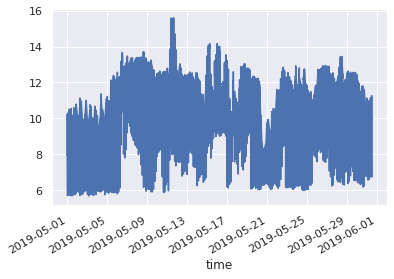

In [8]:
# Timeseries Quickplot
df.ctdpf_ckl_seawater_temperature.plot();               

But what if we want more control on how we plot the data? For this, it's sometimes easier to Matplotlib's plotting functions directly, so we can specify both the x and y axes independently.

Let's use Matplotlib to plot the temperature data vs. pressure.

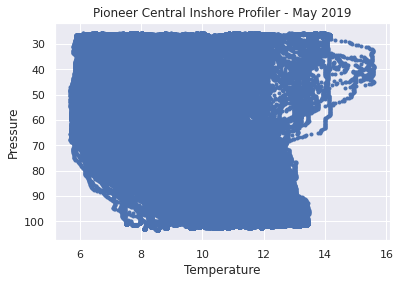

In [9]:
# Profile Plot
plt.plot(df.ctdpf_ckl_seawater_temperature,df.ctdpf_ckl_seawater_pressure, linestyle='', marker='.');

# Flip the y-axis
ax = plt.gca()
ax.invert_yaxis()

# Label the Plot
plt.ylabel('Pressure')
plt.xlabel('Temperature');
plt.title('Pioneer Central Inshore Profiler - May 2019');

This is kind of a crazy plot, because we're plotting an entire month of temperature profiles.  We could subset the data to just one day.

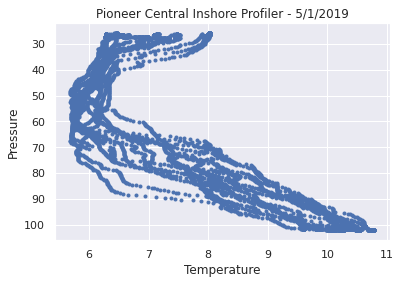

In [10]:
# Subset the dataframe
df2 = df['2019-05-01':'2019-05-01']

# Profile Plot
plt.plot(df2.ctdpf_ckl_seawater_temperature,df2.ctdpf_ckl_seawater_pressure, linestyle='', marker='.');

# Flip the y-axis
ax = plt.gca()
ax.invert_yaxis()

# Label the Plot
plt.ylabel('Pressure')
plt.xlabel('Temperature');
plt.title('Pioneer Central Inshore Profiler - 5/1/2019');

In [11]:
# Your Turn - Remake the plots above with Salinity or Density

So that's interesting.  But to get a more complete picture, let's create a **profile timeseries plot**, which is sometimes called a [Hovmoller](https://en.wikipedia.org/wiki/Hovmöller_diagram) diagram.

This can take some time, depending on how many points you have to plot.

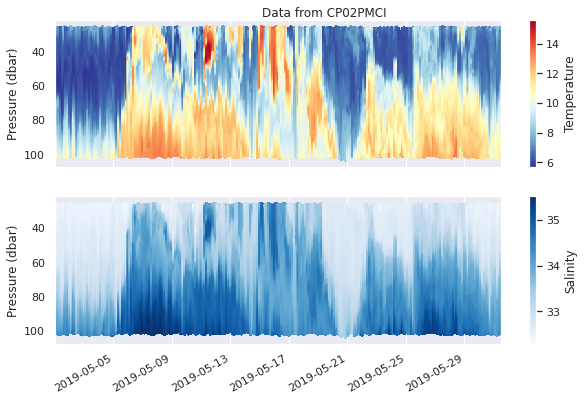

In [12]:
# Scatterplots of Temperature and Salinity
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))

sc1 = ax1.scatter(df.index, df.ctdpf_ckl_seawater_pressure, c=df.ctdpf_ckl_seawater_temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(df.index, df.ctdpf_ckl_seawater_pressure, c=df.practical_salinity, cmap='Blues', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(df.index[0],df.index[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('Data from %s' % ds.subsite)
fig.autofmt_xdate()
fig.subplots_adjust(top=0.95);


This is a very interesting dataset, and certainly not something you see in a textbook.  There's a lot of cool oceanography going on in the Pioneer Array.

## 4. Loading Multiple Files
The above steps worked with a single file... but the data portal will often returns multiple files, especially if your request spans multiple deployments.  Given that the Pioneer Array is redeployed every 6 months, this is likely.

Here is a straight-forward way to load a larger OOI dataset in Python using their THREDDS Server.

In [13]:
# All of 2019 for CP02PMCO
data_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200731T174219126Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html'

In [14]:
def get_datalist(url):
  '''Return all the relevant .nc files from a specified OOI THREDDS url'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets

In [15]:
# List of data files
data_files = get_datalist(data_url)
data_files

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20200731T174219126Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0011_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20190101T000002-20190423T152642.988489.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20200731T174219126Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0012_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20190422T050003-20191008T120159.242857.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20200731T174219126Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191008T140003-20191231T210624.976000.nc#fillmismatch']

In [16]:
%%time
# Load the data files using xarray
data = xr.open_mfdataset(data_files).swap_dims({'obs': 'time'})
print('Dataset has %s points' % "{:,}".format(data.time.size))

Dataset has 3,603,207 points
CPU times: user 1.21 s, sys: 355 ms, total: 1.57 s
Wall time: 12.3 s


## 5. Plotting a Year of Data
Now that we've loaded the data, let's create a quickplot of the temperature.  

For this example, let's use xarray's built in plotting routine, which saves us a few steps, but it may still take a while to display.

CPU times: user 1.94 s, sys: 283 ms, total: 2.22 s
Wall time: 10.3 s


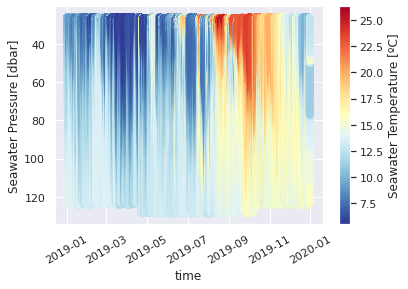

In [17]:
%%time
data.plot.scatter(x='time',y='ctdpf_ckl_seawater_pressure',hue='ctdpf_ckl_seawater_temperature', cmap='RdYlBu_r');
plt.gca().invert_yaxis()
plt.xticks(rotation=30);

## 6. Combining the two Profilers
Now that we have the data from 2 profilers loaded, let's plot them together.  

First we need to subset the Central Offshore profiler to pull out just the month of May.

We could do this is Pandas (as we did above) or xarray (which we will do next).  

In order to do this in xrray, we need to first sort the data, because there are some overlapping times in the dataset when the mooring is redeployed.

In [18]:
%%time
data2 = data.sortby('time')

CPU times: user 7.51 s, sys: 1.17 s, total: 8.68 s
Wall time: 8.71 s


In [19]:
# Subset the Dataset
data2 = data2.sel(time=slice('2019-05-01','2019-06-01'))

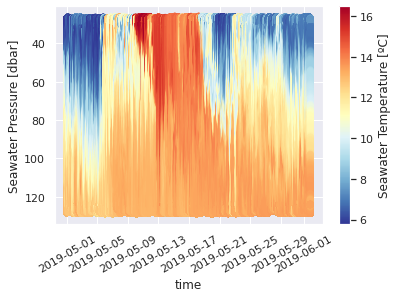

In [20]:
# Quickplot of May 2019 for CP02PMCO
data2.plot.scatter(x='time',y='ctdpf_ckl_seawater_pressure',hue='ctdpf_ckl_seawater_temperature', cmap='RdYlBu_r');
plt.gca().invert_yaxis()
plt.xticks(rotation=30);

Now, let's convert this smaller dataset to a Dataframe so we can plot the two moorings together.

In [21]:
# Specify only a few columns to convert to Pandas DataFrame
df2 = data2[['ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','practical_salinity','density']].to_dataframe()

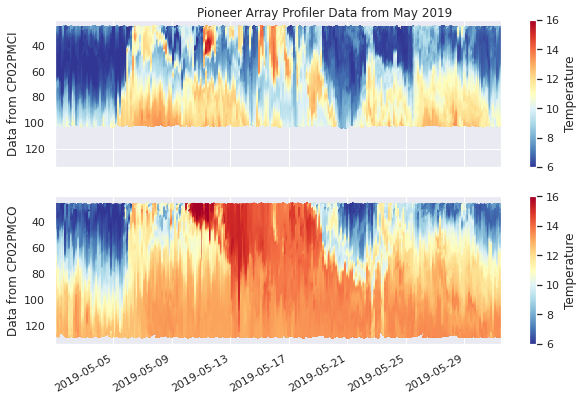

In [22]:
# Both Profilers
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))

sc1 = ax1.scatter(df.index, df.ctdpf_ckl_seawater_pressure, c=df.ctdpf_ckl_seawater_temperature, cmap='RdYlBu_r', s=2, vmin=6, vmax=16)
sc2 = ax2.scatter(df2.index, df2.ctdpf_ckl_seawater_pressure, c=df2.ctdpf_ckl_seawater_temperature, cmap='RdYlBu_r', s=2, vmin=6, vmax=16)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(df.index[0],df.index[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Temperature')

ax1.set_ylabel('Data from %s' % ds.subsite)
ax2.set_ylabel('Data from %s' % data2.subsite)

fig.suptitle('Pioneer Array Profiler Data from May 2019')
fig.autofmt_xdate()
fig.subplots_adjust(top=0.95);

In [23]:
# Your Turn - Recreate the above for salinity

So there are some interesting stories in here.  For another perspective, you could check out some Satellite data, like the SST available from the Rutgers Center for Ocean Observing Leadership's [RU COOL satellite page](https://marine.rutgers.edu/cool/sat_data/?bm=5&bd=1&by=2019&sort=date&em=6&ed=1&ey=2019&region=bigbight&product=sst_comp&nothumbs=0&okb.x=65&okb.y=15).

## 7. Glider Data
Working with glider data requires a few extra steps.  Let's take a look at an Irminger Glider dataset

In [24]:
# Irmginer Glider Dissolved Oxygen & CTD
datafile = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20190509T152634-GI05MOAS-PG528-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/deployment0001_GI05MOAS-PG528-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered_20150817T144410.956600-20160530T193951.630430.nc'

In [25]:
# Load the data files
ds = xr.open_dataset(datafile)
ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
print('Dataset has %d points' % ds.time.size)

# And convert to a Pandas DataFrame - This can take a while with a lot of points
df = ds.to_dataframe()

Dataset has 628560 points


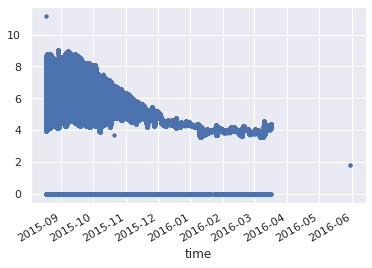

In [26]:
# A quick plot of temperature
df.sci_water_temp.plot(linestyle='',marker='.');

It turns out that gliders (for annoying historical reasons) use 0 as a fill value.  We can use the following code to eliminate those rows.

In [27]:
df = df.where(df.practical_salinity>0)

It also turns out that this dataset has some outliers.  If you try to run the scatterplot code below, or if you plot individual variables, you will discover...
* One point has a salinity value of around 5, when everything should be closer to 35
* One point has a pressure value of 944, but the glider only goes to about 150m
* The last 3 points are dated 5/30, but the last usable data is from 3/17

In [28]:
# Add code here to investigate these outliers using plot, hist, or describe

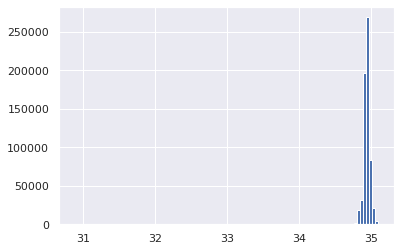

In [29]:
# For example
df.practical_salinity.where(df.practical_salinity>30).hist(bins=100);

We can filter out these outliers using the following code.  

Alternatively, we could always just specify axes limits when creating our plots, which wouldn't require changing the dataset.

In [30]:
# Filter out data after 3/18
df = df.loc[:'2016-03-18'] 

# Filter out data where pressure is greater than 200
df = df.where(df.int_ctd_pressure<200) 

# Filter out data where salinity 
df = df.where(df.practical_salinity>34) 

Now we can make a nice profile timeseries plot.

Notice the vmin/vmax flags in the scatterplot line to specify the colorbar limits to a narrower range.

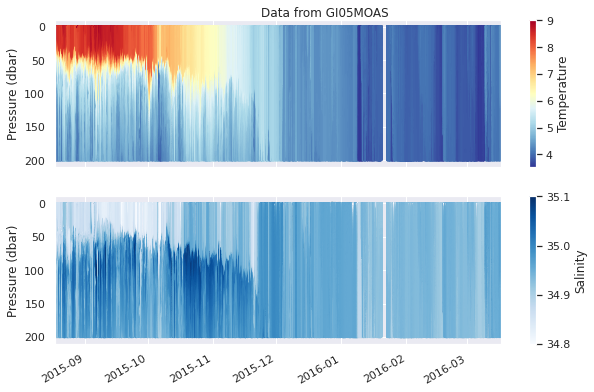

In [31]:
# Scatterplots of Temperature and Salinity
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))

sc1 = ax1.scatter(df.index, df.int_ctd_pressure, c=df.sci_water_temp, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(df.index, df.int_ctd_pressure, c=df.practical_salinity, cmap='Blues', s=2, vmin=34.8, vmax=35.1)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(df.index[0],df.index[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('Data from %s' % ds.subsite)
fig.autofmt_xdate()
fig.subplots_adjust(top=0.95);


## Additional Examples
For more example scripts that work with OOI data, I encourage you to check out these GitHub repositories.
* [Data Lab Blog Examples](https://github.com/ooi-data-lab/datalab-blog-examples) - Especially the following:
  * [How to Request OOI Data](https://datalab.marine.rutgers.edu/2020/05/data-requests-the-easy-way-with-the-ooi-api/)
  * [Merging OOI Datasets](https://datalab.marine.rutgers.edu/2020/05/merging-datasets-for-the-win-and-export/)
  * [Identifying the Sampling Frequency](https://datalab.marine.rutgers.edu/2020/05/identifying-dataset-sample-rates/)
* [Data Lab Nugget Notebooks](https://github.com/ooi-data-lab/nugget-notebooks) - A new collection of notebooks that show how to process data used in these [Data Lab Nuggets](https://datalab.marine.rutgers.edu/data-nuggets/).
* [2018 Data Works](https://github.com/ooi-data-review/2018-data-workshops) - Includes workshop examples, and over 3 dozen Data Review notebooks compiled by participants.
* [2019 Data Lab Workshop](https://github.com/ooi-data-lab/data-lab-workshops) - Includes several tutorials and over 2 dozen notebooks that show how the datasets used in these [Data Explorations](https://datalab.marine.rutgers.edu/explorations/2019/index.php) were processed.